In [1]:
import time
start_time = time.time()
import numpy as np
import pandas as pd

import cv2
from os import listdir
import mnist_reader
import random
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split

from sklearn.decomposition import PCA
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler


from sklearn.ensemble import ExtraTreesClassifier  
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier 

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

from sklearn.metrics import plot_confusion_matrix, plot_roc_curve, roc_curve
from sklearn.metrics import accuracy_score, classification_report


## <u><b> Part 1: </b></u>
### Loading our data


In [2]:
#our random seed for reproducible model
#randomSeed = 834
randomSeed = 36
data, target = mnist_reader.load_mnist(r'data\fashion', kind='train')
final_X_test, final_y_test = mnist_reader.load_mnist(r'data\fashion', kind='t10k')


data,data.shape

(array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 (60000, 784))

In [3]:
target,target.shape

(array([9, 0, 0, ..., 3, 0, 5], dtype=uint8), (60000,))

In [4]:
np.isnan(data).any(),np.isnan(target).any()

(False, False)

In [5]:
#assumes pics are 28x28
def plotIMGS(data,size):
    fig, axs = plt.subplots(size, size)
    fig.set_size_inches(2.8*size,2.8*size)
    for i in range(len(axs)):
        for j in range(len(axs[i])):
            label = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
            idx = random.randint(0,len(data)-1)
            axs[i,j].imshow(data[idx].reshape((28,28)),cmap="gray",vmin=0, vmax=255)
            axs[i,j].set_title(label[target[idx]])

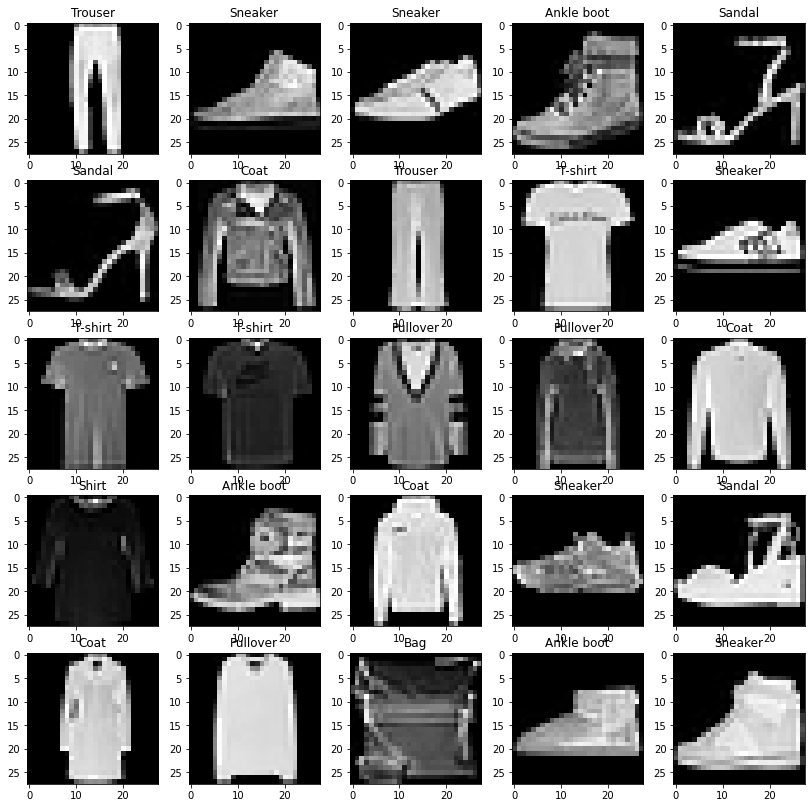

In [6]:
plotIMGS(data,5)

## <u><b> Part 2 </b></u>

### Train/Test split

We will find a model that that can predict our train data well before trying it on the entire final train and final test data 

In [7]:
X_train,X_test,y_train,y_test=train_test_split(data,target,test_size=0.25,random_state=randomSeed)

## <u><b> Part 3 </b></u>
### Feature engineering

We will add, remove and augment some features in order to make a more accurate model that requires less data

We will add features to the data that show us the amount of black contours and the area, length, width, height, centerX, centerY of each clothing piece

In [8]:
#Takes a 28*28 picture and returns the size of the clothing part and the amount of black contours in the pic 
# (contours#, area, length, width, height, centerX, centerY)
def itemSize(pic,tol=1,example = False):
    #to determin img size
    ret, clothing = cv2.threshold(pic.copy(),tol,255,cv2.THRESH_BINARY)
    contours2,hierarchy = cv2.findContours(clothing.copy(),cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)
    c_0 = contours2[0]
    if len(contours2) > 1:

        contours2 = np.concatenate(contours2)
        c_0 = contours2
        
    M = cv2.moments(c_0)
    
    cX = sum(c_0[:,:,0])/len(c_0)
    cY = sum(c_0[:,:,1])/len(c_0)

    x, y, w, h = cv2.boundingRect(c_0)
    length = cv2.arcLength(c_0, closed = True)
    area = cv2.contourArea(c_0)

    ret, background = cv2.threshold(pic.copy(),tol,255,cv2.THRESH_BINARY_INV)
    #get black contours
    contours, hierarchy = cv2.findContours(background.copy(),cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)
    if example:
        white = cv2.cvtColor(pic,cv2.COLOR_GRAY2BGR)
        img = cv2.drawContours(white.copy(), contours, -1, (0,255,0), 1)
        img2 = cv2.drawContours(white.copy(), contours2, -1, (255,0,0), 1)
        return img, background,img2,clothing
    return len(contours),area,length,w,h,x+w/2,y+h/2,cX[0],cY[0]
        

(5,
 132.0,
 93.94112491607666,
 28,
 12,
 14.0,
 14.0,
 14.31578947368421,
 13.763157894736842)

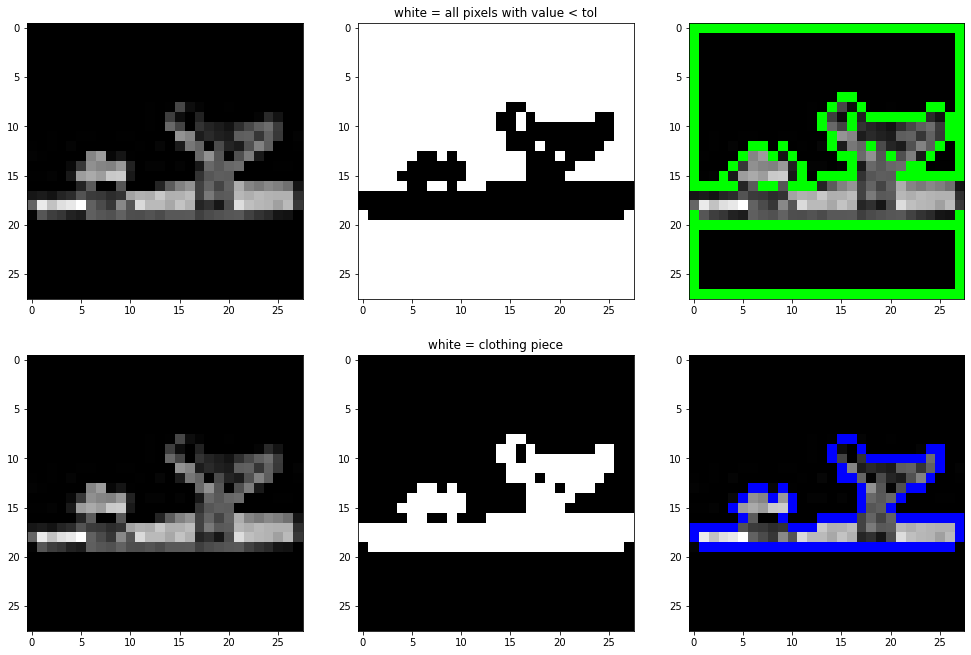

In [9]:
temp = data[-1].reshape((28,28))
pic1,thresh1,pic2,thresh2 = itemSize(temp,tol=10,example = True)
fig, ((ax11,ax21,ax31),(ax12,ax22,ax32)) = plt.subplots(2, 3)
fig.set_size_inches(2.8*6,2.8*4)

ax11.imshow(temp,cmap="gray",vmin=0, vmax=255)
ax21.set_title("white = all pixels with value < tol")
ax21.imshow(thresh1,cmap="gray",vmin=0, vmax=255)
ax31.imshow(cv2.cvtColor(pic1,cv2.COLOR_BGR2RGB))

ax12.imshow(temp,cmap="gray",vmin=0, vmax=255)
ax22.set_title("white = clothing piece")
ax22.imshow(thresh2,cmap="gray",vmin=0, vmax=255)
ax32.imshow(cv2.cvtColor(pic2,cv2.COLOR_BGR2RGB))
itemSize(temp,tol=10)


In [10]:
def scanRows(pic,lines=4,mode="uniform",tol=10):
    row_num = []
    black_count = []
    black_lines = []
    if mode == "uniform":
        row_num = [random.randint(int(i*(28/lines)), int((i+1)*(28/lines))-1 ) for i in range(lines)]
    else:
        row_num = np.random.randint(0,28,lines)
    
    for row in row_num:
        in_row = False
        black = 0
        line_count = []
        for pixel in pic[row]:
            if pixel <= tol:
                black+=1
                in_row = True
            elif in_row:
                line_count.append(black)
                black = 0
                in_row = False
        black_count.append(sum(line_count))
        black_lines.append(len(line_count))
    return sum(black_count), black_lines


#### PCA

We want our model to use the least amount of paramaters so we will use dimensionality reduction and keep 95% of our features variance 

In [11]:
def get_pca(data,threashold=0.95):
    pca = PCA(random_state=randomSeed)
    pca.fit(data)
    exp_var_cumul = np.cumsum(pca.explained_variance_ratio_)
    dim = len(exp_var_cumul[exp_var_cumul<threashold])
    return dim

## <u><b> Part 4 </b></u>
### Pipeline

We will construct our pipeline using the methods we made before

In [12]:
class Add_row_scan(BaseEstimator, TransformerMixin):
    def __init__(self,tol=10,mode="uniform",lines=4):
        self.tol = tol
        self.mode = mode
        self.lines = lines
    def fit(self, Data, y=None):
        return self
    def transform(self,Data,y=None):
        newData = []
        for i in Data:
            black_n, lines_lens = scanRows(i.reshape(28,28),tol=self.tol,lines=self.lines,mode=self.mode)
            lines_lens.append(black_n)
            newData.append([i, lines_lens])
        return newData

In [13]:
class best_PCA(BaseEstimator, TransformerMixin):
    def __init__(self,threashold=0.95,random_state=None):
        self.threashold = threashold
        self.random_state = random_state
        self.dim = 0
        self.final_pca = PCA(random_state=self.random_state)
        self.is_fit = False
    
    def fit(self, Data, y=None):
        self.dim = get_pca(Data)
        self.final_pca = PCA(n_components=self.dim,random_state=self.random_state)
        self.final_pca.fit(Data)
        self.is_fit = True
        return self
    def transform(self,Data,y=None):
        if self.is_fit:
            newData = self.final_pca.transform(Data)
            return newData
        return Data

In [14]:
class Add_Sizes(BaseEstimator, TransformerMixin):
    def __init__(self,tol=10):
        self.tol = tol
    def fit(self, Data, y=None):
        return self
    def transform(self,Data,y=None):
        newData = []
        for i in Data:
            extra_features = itemSize(i[0].reshape(28,28),tol=self.tol)
            newData.append(np.concatenate((i[0],i[1], extra_features)))
        return newData

In [15]:
pipe = Pipeline([
    ("scale",StandardScaler()),
    ("pca",best_PCA(random_state=randomSeed))
],verbose=True)

## <u><b> Part 5 </b></u>
### Baseline model

We will make a baseline without any transformations and try to beat it

In [16]:
baseline = RandomForestClassifier(n_estimators=10)
baseline.fit(X_train,y_train)

RandomForestClassifier(n_estimators=10)

In [17]:
baseline_predict = baseline.predict(X_test)

In [18]:
print("Accuracy:",accuracy_score(y_test,baseline_predict))
print(classification_report(y_test,baseline_predict))

Accuracy: 0.8571333333333333
              precision    recall  f1-score   support

           0       0.77      0.85      0.81      1476
           1       0.98      0.96      0.97      1517
           2       0.74      0.80      0.77      1496
           3       0.85      0.88      0.87      1505
           4       0.74      0.78      0.76      1493
           5       0.95      0.94      0.94      1491
           6       0.71      0.54      0.61      1490
           7       0.91      0.92      0.92      1519
           8       0.96      0.96      0.96      1526
           9       0.94      0.94      0.94      1487

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.85     15000
weighted avg       0.86      0.86      0.86     15000



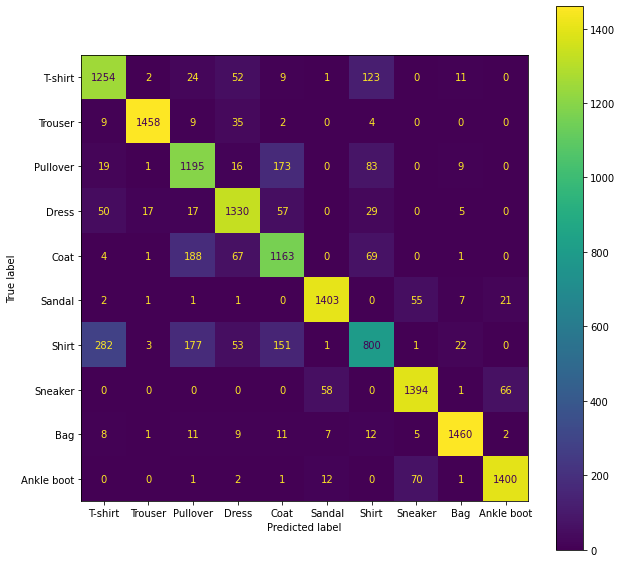

In [19]:
fig, (ax1) = plt.subplots(1, 1)
 
fig.set_size_inches(10,10)
plot_confusion_matrix(baseline,X_test,y_test,display_labels=["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"],values_format="d",ax=ax1)


## <u><b> Part 6 </b></u>
### Final model

Since we have a problem classifying very similar clothing items, lets instead make our data simpler,
we will change our target lables so that each label represents more than one clothing type,
then, we will sort each lable to its own data set and try to predict what clothing piece it is
given the type

For example, we are combining the sandal, sneaker and ankle boot into one label, then we will make
model that will predict what sub-class each item is part of, then we take only the shoe-like items
and pass them into another model to predict what kind of shoe it is

In [20]:
X_train_new = pipe.fit_transform(X_train)
X_train_new.shape

[Pipeline] ............. (step 1 of 2) Processing scale, total=   0.9s
[Pipeline] ............... (step 2 of 2) Processing pca, total=   9.6s


(45000, 254)

In [21]:
X_test_new = pipe.transform(X_test)
X_test_new.shape

(15000, 254)

In [22]:
def mapping_func1(x):
    #shirt-like
    if x == 0 or x==2 or x==4 or x==6 or x==3:
        return 0
    #shoe like
    elif x==9 or x==7 or x==5:
        return 1
    #Trouser
    elif x==1:
        return 2
    #Bag
    elif x==8:
        return 3

In [23]:
f = lambda x: np.array([mapping_func1(i) for i in x])
y_train_new = f(y_train)
y_test_new = f(y_test)

In [24]:
model_0 = RandomForestClassifier(n_estimators=10)
model_0.fit(X_train_new,y_train_new)

RandomForestClassifier(n_estimators=10)

In [25]:
model_0_predict = model_0.predict(X_test_new)

In [26]:
print("Accuracy:",accuracy_score(y_test_new,model_0_predict))
print(classification_report(y_test_new,model_0_predict))

Accuracy: 0.969
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      7460
           1       0.98      0.99      0.99      4497
           2       1.00      0.92      0.96      1517
           3       0.97      0.83      0.90      1526

    accuracy                           0.97     15000
   macro avg       0.98      0.93      0.95     15000
weighted avg       0.97      0.97      0.97     15000



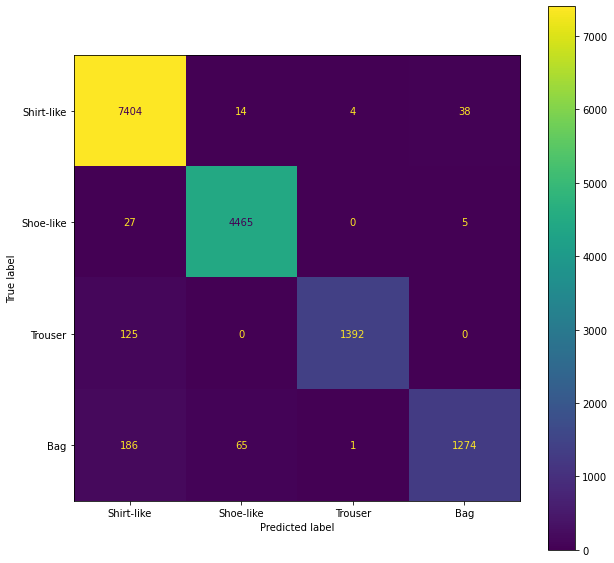

In [27]:
fig, (ax1) = plt.subplots(1, 1)

fig.set_size_inches(10,10)
plot_confusion_matrix(model_0,X_test_new,y_test_new,display_labels=["Shirt-like","Shoe-like","Trouser","Bag"],values_format="d",ax=ax1)

In [28]:
trainDF = pd.DataFrame(X_train)
trainDF["target"] = y_train_new
trainDF["real_target"] = y_train

testDF = pd.DataFrame(X_test)
testDF["target"] = model_0_predict


trainDF.head(10)

0  1  2  3  4  5   6   7   8    9  ...  776  777  778  779  780  781  782  \
0  0  0  0  0  0  0   0   0   0    0  ...    0    0    0    0    0    0    0   
1  0  0  0  0  0  0   0   0   0    0  ...    0    0    0    0    0    0    0   
2  0  0  0  0  0  0   0   0   0    0  ...    0    0   90   53   42   32   29   
3  0  0  0  0  0  0   0  29  62   76  ...    0    0   56  111  106   12    0   
4  0  0  0  0  0  0  46  73   0    6  ...    4   35    0    0    0    0    0   
5  0  0  0  0  0  0   0   0   0    2  ...    0    0    0    0    0    0    0   
6  0  0  0  0  0  0   0   0   0    0  ...    0    0    0    0    0    0    0   
7  0  0  0  0  0  3   0   0   0    0  ...   20    0    0    0    0    0    0   
8  0  0  0  0  0  0   0   0   0    0  ...    0    0    0    0    0    0    0   
9  0  0  0  0  0  0   0   0   0  102  ...   93    0    0    0    0    0    0   

   783  target  real_target  
0    0       1            7  
1    0       3            8  
2    0       1            9  
3    0       0            2  
4    0       0            0  
5    0       0            6  
6    0       1            5  
7    0       0            0  
8    0       1            7  
9    0       2            1  

[10 rows x 786 columns]

In [29]:
trainSets = [trainDF[trainDF["target"]==label] for label in [0,1,2,3]]
testSets = [testDF[testDF["target"]==label] for label in [0,1,2,3]]

Feature importance

In [30]:
#shirt_forest = ExtraTreesClassifier(n_estimators=250,random_state=randomSeed)
#shoe_forest = ExtraTreesClassifier(n_estimators=250,random_state=randomSeed)
#shirt_forest.fit(trainSets[0].drop(columns=["real_target"]),trainSets[0]["real_target"])


In [31]:
#shoe_forest.fit(trainSets[1].drop(columns=["real_target"]),trainSets[1]["real_target"])

In [32]:
#pixels_shirt = shirt_forest.feature_importances_[:-1].reshape((28,28))
#pixels_shoe = shoe_forest.feature_importances_[:-1].reshape((28,28))
#sns.heatmap(pixels_shirt)
#sns.heatmap(pixels_shoe)

In [33]:
def plot_avg_pixels(data):
    size = len(data["real_target"].unique())
    i = 0
    j = 0
    fig, axes = plt.subplots(size, size,sharex=True,sharey=True)
    fig.set_size_inches(2.9*size,2.9*size)
    cbar_ax = fig.add_axes([.91, .3, .03, .4])
    labels = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]
    for pos in data["real_target"].unique():
        j=0
        for neg in data["real_target"].unique():
            mean_pixels_pos = data[data["real_target"] == pos].describe().loc["mean"]
            mean_pixels_neg = data[data["real_target"] == neg].describe().loc["mean"]
            diff = mean_pixels_pos - mean_pixels_neg
            sns.heatmap(diff.to_numpy()[:-2].reshape((28,28)),ax=axes[i,j],cmap="vlag",vmin=-255, vmax=255,cbar_ax=cbar_ax)
            axes[i,j].tick_params(axis='both',which='both',left=False,right=False,bottom=False,top=False,labelbottom=False,labelleft=False)
            axes[i,j].set_title(labels[pos]+"  -  "+labels[neg])
            j+=1
        i+=1

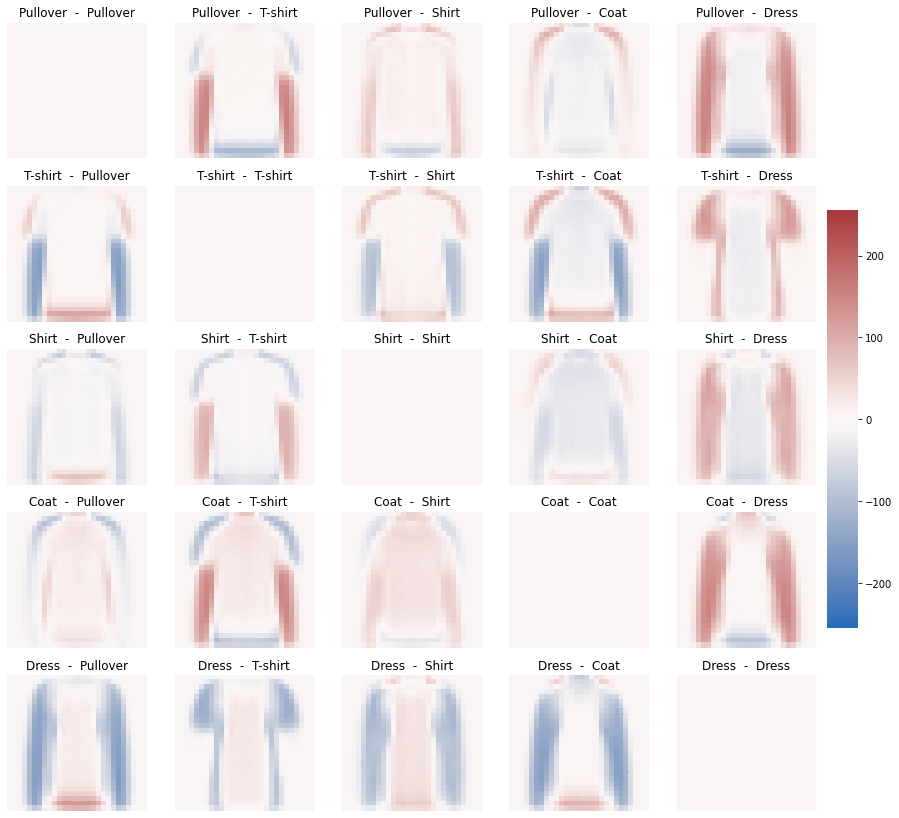

In [34]:
plot_avg_pixels(trainSets[0])

We can see now how to identify between the cloths notice that: 

1. if it has long sleeves --> pullover, shirt or coat 
    1.1 if it is short in the chest area --> coat or pullover
        1.1.1 if it is wide near the top --> pullover

2. if it is wide near the top + short sleeves + long in the chest area --> T-shirt

3. if it is long in the chest area + short or no sleeves + not wide -- > dress

So we will add features that describe:

1. sleeve length

2. wideness at the top x pixels 

3. chest length

4. widest point hight

5. widest point length


In [35]:
def shirt_features(pic,top_rows=8,tol=10,eps=4):
    img = np.uint8(pic.reshape((28,28)))
    ret,thresh = cv2.threshold(img.copy(),tol,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)
    c_0 = contours[0]
    if len(contours) > 1:
        contours = np.concatenate(contours)
        
        c_0 = contours
    contours = c_0
    newIMG = np.zeros_like(img)
    newIMG = cv2.drawContours(newIMG, contours, -1, color=1, thickness=-1)
    

    columns = np.sum(newIMG,axis=0)
    rows = np.sum(newIMG,axis=1)

    

    #top x pixels
    top_x_wide = sum(rows[:top_rows])

    #chest length
    chest_length = sum(columns[14-eps:15+eps])

    #max width
    max_width_idx = np.argmax(rows)
    max_width_size = rows[max_width_idx]

    return np.array([top_x_wide, chest_length, max_width_idx, max_width_size])

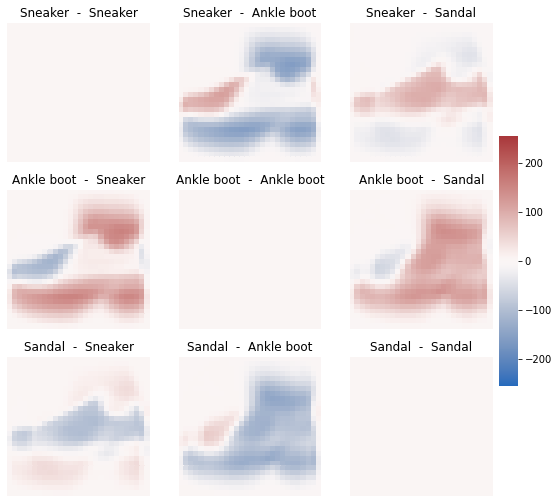

In [36]:
plot_avg_pixels(trainSets[1])

We can clearly see that by getting the size and postion of the shoe can determin what type of shoe it is,

high pixels to height/width ratio --> ankle boot

near the middle of the img --> sneaker

low pixels to height/width ratio  --> sandal


So we will add features that describe:

1. ratio between height and width to total pixels of shoe

2. row number of the bottom of the shoe

In [37]:
def shoe_features(pic,tol=10):
    img = np.uint8(pic.reshape((28,28)))
    ret,thresh = cv2.threshold(img.copy(),tol,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL ,cv2.CHAIN_APPROX_SIMPLE)
    c_0 = contours[0]
    if len(contours) > 1:
        contours = np.concatenate(contours)
        c_0 = contours
    contours = c_0
    newIMG = np.zeros_like(img)
    newIMG = cv2.drawContours(newIMG, contours, -1, color=1, thickness=-1)
    
    columns = np.sum(newIMG,axis=0)
    rows = np.sum(newIMG,axis=1)
    
    last_row_idx = 0
    flg = False
    for row in rows:
        if flg and row==0:
            break
        elif row>0:
            flg = True
        last_row_idx+=1

    #max width
    max_width = np.amax(rows)
    max_height = np.amax(columns)
    out = max_width*max_height/np.sum(rows)

    return np.array(last_row_idx, out)

In [38]:
def get_new_data(data,target,top_rows=8,tol=10,eps=4):
    newData = []
    for row in data.iterrows():
        r = row[1][:784].to_numpy()
        if target == "shirt":
            newData.append(shirt_features(r,top_rows=top_rows,tol=tol,eps=eps))
        elif target == "shoe":
            newData.append(shirt_features(r,tol=tol))
    return pd.DataFrame(newData)

In [39]:
class reduce_range(BaseEstimator, TransformerMixin,ClassifierMixin):
    def __init__(self,model,pca=None):
        self.model = model
        self.pca = pca
    def fit(self,X,y):
        f = lambda x: np.array([mapping_func1(i) for i in x])
        new_y = f(y)
        new_X = X
        if self.pca != None:
            new_X = self.pca.fit_transform(X)

        self.model.fit(new_X,new_y)

        return self

    def transform(self,X,y=None):
        new_X = X
        if self.pca != None:
            new_X = self.pca.transform(X)

        target = self.model.predict(new_X)
        df = pd.DataFrame(X)
        df["target"] = target
        df["idx"] = np.arange(len(X))
        df = [df[df["target"]==label] for label in [0,1,2,3]]
        return df
    
    def fit_transform(self,X,y=None):
        self.fit(X,y)
        newX = self.transform(X,y)
        return newX

In [40]:
class find_new_data(BaseEstimator, TransformerMixin,ClassifierMixin):
    def __init__(self,top_rows=8,tol=10,eps=4):
        self.top_rows = top_rows
        self.tol = tol
        self.eps = eps
    def fit(self,X,y):
        return self
    def transform(self,X,y=None):
        new_data = [df.reset_index() for df in X]
        a = X[0].reset_index()
        new_data[0]  = pd.concat([new_data[0], get_new_data(X[0],"shirt",top_rows=self.top_rows,tol=self.tol,eps=self.tol)],axis=1)
        #new_data[0]["target"] = a["target"]
        #new_data[0]["idx"] = a["idx"]
        
        a = X[1].reset_index()
        new_data[1] = pd.concat([new_data[1], get_new_data(X[1],"shoe",tol=self.tol)], axis=1)
        #new_data[1]["target"] = a["target"]
        #new_data[1]["idx"] = a["idx"]
        return new_data
    def fit_transform(self,X,y=None):
        self.fit(X,y)
        newX = self.transform(X,y)
        return newX

In [52]:
class model(BaseEstimator, ClassifierMixin):
    def __init__(self, model1,model2,model3,model4,pcas=[None,None,None,None]):
        self.model1 = model1
        self.model2 = model2
        self.model3 = model3
        self.model4 = model4
        
        self.models = [model1,model2,model3,model4]
        self.pcas = pcas
    def fit(self, X, y):

        for i in range(len(self.models)):
            new_X = X[i].drop(columns=["idx"])
            
            new_y = [y[j] for j in X[i]["idx"]]
    
            if self.pcas[i] != None:
                new_X = self.pcas.fit_transform(new_X)
            self.models[i].fit(new_X,new_y)
            
    def predict(self, X):
        pred = np.zeros(sum([len(data["idx"]) for data in X ]))
        for i in range(len(self.models)):
            new_X = X[i].drop(columns=["idx"])
            if self.pcas[i] != None:
                new_X = self.pcas[i].transform(new_X)
            pred[X[i]["idx"]] = self.models[i].predict(new_X)
        return pred
    def transform(self,X,y=None):
        return X
    def fit_transform(self,X,y=None):
        self.fit(X,y)
        
        newX = self.transform(X,y)
        return newX

In [53]:
classifiers = [
    RandomForestClassifier(n_estimators=10,random_state=randomSeed),RandomForestClassifier(n_estimators=20,random_state=randomSeed),
    RandomForestClassifier(n_estimators=50,random_state=randomSeed),RandomForestClassifier(n_estimators=100,random_state=randomSeed),
    DecisionTreeClassifier(random_state=randomSeed),
    KNeighborsClassifier(n_neighbors=5),KNeighborsClassifier(n_neighbors=10),KNeighborsClassifier(n_neighbors=20),KNeighborsClassifier(n_neighbors=50),
    KNeighborsClassifier(n_neighbors=100),KNeighborsClassifier(n_neighbors=200),
    LogisticRegression(max_iter=100,C=1,random_state=randomSeed),LogisticRegression(max_iter=200,C=1,random_state=randomSeed),
    LogisticRegression(max_iter=100,C=0.1,random_state=randomSeed),LogisticRegression(max_iter=200,C=0.1,random_state=randomSeed)
]
vote_classifiers = [("model"+str(i), classifiers[i]) for i in range(len(classifiers))]
classifiers.append(vote_classifiers)
pca = PCA(n_components=get_pca(X_train),random_state=randomSeed)

In [54]:
m0 = RandomForestClassifier(n_estimators=10,random_state=randomSeed)
m1 = RandomForestClassifier(n_estimators=10,random_state=randomSeed)
m2 = RandomForestClassifier(n_estimators=10,random_state=randomSeed)
m3 = RandomForestClassifier(n_estimators=10,random_state=randomSeed)
m4 = RandomForestClassifier(n_estimators=10,random_state=randomSeed)


In [55]:

pipe2 = Pipeline([
    ("reduce range",reduce_range(m0)),
    ("new Data",find_new_data(top_rows=8,tol=10,eps=3)),
    ("model",model(m1,m2,m3,m4))

],verbose=True)

In [59]:
param_grid = {
    'reduce range__model':classifiers,
    'reduce range__pca':[pca],
    'model__pcas':[pca,pca,pca,pca],
    'model__model1':classifiers,
    'model__model2':classifiers,
    'model__model3':classifiers,
    'model__model4':classifiers
}

In [60]:
grid = RandomizedSearchCV(pipe2, param_grid, random_state=randomSeed,n_iter=500,n_jobs=-1,verbose=4)

In [61]:
grid.fit(X_train,y_train)

In [219]:
pipe2 = grid.best_estimator_

[Pipeline] ...... (step 1 of 3) Processing reduce range, total=   8.2s
[Pipeline] .......... (step 2 of 3) Processing new Data, total=   8.3s
[Pipeline] ............. (step 3 of 3) Processing model, total=   4.3s


Pipeline(steps=[('reduce range',
                 reduce_range(model=RandomForestClassifier(n_estimators=10,
                                                           random_state=36))),
                ('new Data', find_new_data(eps=3)),
                ('model',
                 model(models=[RandomForestClassifier(n_estimators=10,
                                                      random_state=36),
                               RandomForestClassifier(n_estimators=10,
                                                      random_state=36),
                               RandomForestClassifier(n_estimators=10,
                                                      random_state=36),
                               RandomForestClassifier(n_estimators=10,
                                                      random_state=36)]))],
         verbose=True)

In [220]:
pred = pipe2.predict(X_test)

In [221]:
print("Accuracy:",accuracy_score(y_test,pred))
print(classification_report(y_test,pred))

Accuracy: 0.8584666666666667
              precision    recall  f1-score   support

           0       0.76      0.85      0.81      1476
           1       0.99      0.95      0.97      1517
           2       0.74      0.79      0.77      1496
           3       0.86      0.91      0.88      1505
           4       0.75      0.78      0.77      1493
           5       0.95      0.94      0.95      1491
           6       0.68      0.54      0.60      1490
           7       0.91      0.93      0.92      1519
           8       0.98      0.94      0.96      1526
           9       0.94      0.94      0.94      1487

    accuracy                           0.86     15000
   macro avg       0.86      0.86      0.86     15000
weighted avg       0.86      0.86      0.86     15000



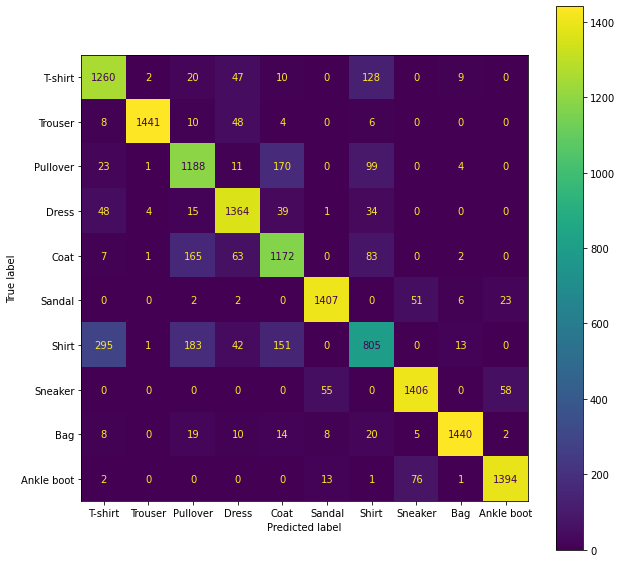

In [222]:
fig, (ax1) = plt.subplots(1, 1)
 
fig.set_size_inches(10,10)
plot_confusion_matrix(pipe2,X_test,y_test,display_labels=["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"],values_format="d",ax=ax1)